# Optimization F24 Linear programming project

by Dmitry Beresnev (<d.beresnev@innopolis.university>)
and Vsevolod Klyushev (<v.klyushev@innopolis.university>)

Group ID = 2


In [1]:
import time
from itertools import zip_longest
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import scipy.linalg
import scipy.optimize
from tqdm import tqdm

## Utilities


### Decoding/encoding


In [2]:
def encoding_bin(mess: str, as_float: bool = False) -> tuple[np.ndarray, int]:
    """Encodes string into binary vector

    Args:
        mess (str): initial string
        as_float (bool): whether to convert output vector to floats. Defaults to False.

    Returns:
        tuple[np.ndarray, int]: (1d binary vector, number of bits per character)
    """

    # Convert each character to its ASCII value and then to binary
    xi = [format(ord(char), "08b") for char in mess]

    max_len = len(max(xi, key=len))
    xi = [f"{'0'*(max_len -len(bit_str))}{bit_str}" for bit_str in xi]

    # Convert each binary string to a binary vector
    x = np.array([[int(bit) for bit in bit_str] for bit_str in xi])

    # Return the binary vector and its dimensions
    d = x.shape[1]  # Number of bits per character
    x = x.flatten()  # convert into a 1-d vector

    if as_float:
        x = x.astype(np.float32)
    return x, d


def decoding_bin(x: np.ndarray, d: int) -> tuple[str, np.ndarray]:
    """Decodes a binary vector into string

    Args:
        x (np.ndarray): 1d binary vector
        d (int): number of bits per character

    Returns:
        tuple[str, np.ndarray]: (decoded string, binary matrix)
    """

    # Ensure x is a binary vector (0s and 1s)
    x = np.clip(x, 0, 1)  # Clip values to be between 0 and 1
    x = np.round(x)  # Round values to the nearest integer

    # Initialize the output array
    y = np.zeros((len(x) // d, d), dtype=int)

    k = 0
    for i in range(len(x) // d):
        for j in range(d):
            y[i, j] = int(x[k])  # Fill the binary matrix
            k += 1

    # Convert binary to decimal and then to characters
    mess = "".join(chr(int("".join(map(str, row)), 2)) for row in y)

    return mess, y

In [3]:
# Try it
message_in = "So happy to see you"
print(f"Message sent: {message_in}")
binary_vector, dimensions = encoding_bin(message_in)
print(f"Dimensions: {dimensions}")
print(f"Binary Vector:\n{binary_vector}")
float_vector = binary_vector.astype(np.float32)
message_decoded, binary_matrix = decoding_bin(float_vector, dimensions)
print(f"Decoded message: {message_decoded}")

Message sent: So happy to see you
Dimensions: 8
Binary Vector:
[0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0
 0 0 1 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1
 0 1 0 1]
Decoded message: So happy to see you


### Channel simulation


In [4]:
def noisy_channel(y: np.ndarray, percent_error: float, seed: Optional[int] = None) -> np.ndarray:
    """Simulates effect of the noisy channel.
    Disrupts percent_error% of y entries randomly

    Args:
        y (np.ndarray): input signal
        percent_error (float): percent of information to disrupt
        seed (Optional[int]): numpy random seed. Defaults to None.

    Returns:
        np.ndarray: noisy signal
    """

    if seed is not None:
        np.random.seed(seed)

    m = len(y)  # Length of the message
    k = int(np.floor(m * percent_error))  # Number of entries to corrupt
    indices = np.random.permutation(m)[:k]  # Random indices to corrupt
    y_n = np.copy(y)  # Copy of the original message
    vec = np.random.rand(k) * np.mean(y)
    y_n[indices] = vec  # Corruption of selected inputs
    return y_n

In [5]:
# Try it
message_in = "A crystal clear message"
float_vector, dimensions = encoding_bin(message_in, as_float=True)

y_prime = noisy_channel(float_vector, percent_error=0.05, seed=420)
print(f"Message sent: {message_in}")

message_corr_decoded, binary_matrix = decoding_bin(y_prime, dimensions)
print(f"Decoded noisy message: {message_corr_decoded}")

Message sent: A crystal clear message
Decoded noisy message: A cbyS0aL clear messaga


### Data loading


In [6]:
def load_data(path: str = "./data/messageFromAlice.mat") -> tuple[np.ndarray, np.ndarray, int]:
    """Loads .mat file from disk

    Args:
        path (str, optional): Path to data. Defaults to './data/messageFromAlice.mat'.

    Returns:
        tuple[np.ndarray, np.ndarray, int]: (encoding_matrix, received_signal, dimension)
    """

    data = scipy.io.loadmat(path)
    # data is dictionary where
    ## data['A'] is the encoding matrix exchanged between Alice and Bob
    ## data['d'] is the dimension
    ## data['yprime'] is the encrypted message received from Alice

    # Load the arrays
    y_prime = data["yprime"].T
    y_prime = np.squeeze(y_prime)

    return data["A"], y_prime, data["d"][0][0]

## Question 1


_Q1: Model the problem as a linear program. Explain your reasoning_


Initial problem: $\min\limits_{x' \in \mathbb{R}^p} \| Ax'-y' \|_1$ such that $0 \leq x' \leq 1$

Note that $ \| Ax'-y' \|_1 = \sum_{i=1}^{m} |{(Ax')}\_i-y'\_i|$, where $( \cdot )_i$ - i-th component of vector.

Each element $|{(Ax')}_i-y'_i| = \max({(Ax')}_i-y'_i, y'_i -{(Ax')}_i)$ can be substituted with new variable $z'$ with the following additional
constraints: $z_i \geq {(Ax')}_i-y'_i$ and $z_i \geq y'_i-{(Ax')}_i$

Therefore, we can formulate the following linear programming problem, which is equivalent to the initial one:

$$
\begin{aligned}
& \min\limits_{x' \in \mathbb{R}^p, z \in \mathbb{R}^m} \sum_{i=1}^{m} z_i \\
\textbf{s.t. } &x' \geq 0 \\
&x' \leq 1 \\
& z_i \geq {(Ax')}_i-y'_i, i = 1 \dots m\\
& z_i \geq y'_i-{(Ax')}_i, i = 1 \dots m \\
\end{aligned}
$$


## Question 2


_Q2: Write this linear problem in standard form_


Let us firstly rewrite problem in **geometric** form:

$$
\begin{aligned}
& \min\limits_{z' \in \mathbb{R}^{p+m}} c^Tz' \\
\textbf{s.t. } &A' z' \geq b',
\end{aligned}
$$

where
$c \in \mathbb{R}^{p+m} = \sum\_{i=p+1}^{p+m} e_i $,

$b' = (0_p, -1_p, -y', y')^T$,

$A' = \begin{pmatrix}
I_p & 0 \\
-I_p &  0 \\
-A & I_m \\
A & I_m
\end{pmatrix} \in \mathbb{R}^{(2p+2m) \times (p+m)}
$,

$e_i$ - unit vector with 1 at index $i$ and all other zeroes,

$0_p$ - vector of $p$ zeroes,

$1_p$ - vector of $p$ ones,

$I_k$ - identity matrix of size $k \times k$.


Note, that by construction $z' = (x', z)^T \geq 0$, because $x' \geq 0$ by problem definition and $z \geq 0 $ by construction, as represents an absolute value.

Now we are ready to rewrite problem in **standard** form:

$$
\begin{aligned}
& \min\limits_{\tilde{x} \in \mathbb{R}^{2p+3m}} c^T\tilde{x} \\
\textbf{s.t. } &A' \tilde{x} = b \\
&\tilde{x} \geq 0,
\end{aligned}
$$

where
$c \in \mathbb{R}^{2p+3m} = \sum\_{i=p+1}^{p+m} e_i $,

$b' = (-1_p, -y', y')^T$,

$A' = \begin{pmatrix}
-I_p &  0 &  \\
-A & I_m & -I_{p+2m}\\
A & I_m &
\end{pmatrix} \in \mathbb{R}^{(p+2m) \times (2p+3m)}
$,

$-I_{p+2m}$ - slack variable matrix,

$1_p$ - vector of $p$ ones,

$I_k$ - identity matrix of size $k \times k$,

$e_i$ - unit vector with 1 at index $i$ and all other zeroes.


Also note, that initial message (that we are interested in) is the first $p$ components of $\tilde{x}$


## Question 3


_Q3: Use the function linprog2
from the Python scientific computation library SciPy to decrypt
the message provided on the course website (messageFromAlice.mat). What is the message
sent by Alice?_


In [7]:
def extract_message_naive(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using naive approach (asuuming no noise)

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    res, *_ = scipy.linalg.lstsq(a=encoding_matrix, b=noisy_signal)
    return res, res

In [8]:
def extract_message_geometric(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using (almost) geometric form of linear optimization problem

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    # Size of A
    (m, p) = encoding_matrix.shape

    c = np.zeros(p + m)
    c[p : p + m] = np.ones(m)

    b = np.concat([np.zeros(p), -np.ones(p), -noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat([np.identity(p), np.zeros((p, m))], axis=1),
            np.concat([-np.identity(p), np.zeros((p, m))], axis=1),
            np.concat(
                [-encoding_matrix, np.identity(m)],
                axis=1,
            ),
            np.concat(
                [
                    encoding_matrix,
                    np.identity(m),
                ],
                axis=1,
            ),
        ]
    )

    # We add minuses, because from scipy documentation
    # A_ub x <= b_ub
    # But in geometric from we have constraints
    # A_ub x >= b_ub
    res = scipy.optimize.linprog(c, A_ub=-A, b_ub=-b, method="highs")

    return res.x, res.x[:p]

In [9]:
def extract_message_standard(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using standard form of linear optimization problem

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    # Size of A
    (m, p) = encoding_matrix.shape

    c = np.zeros(2 * p + 3 * m)
    c[p : p + m] = np.ones(m)

    b = np.concat([-np.ones(p), -noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat(
                [
                    np.concat([-np.identity(p), np.zeros((p, m))], axis=1),
                    np.concat(
                        [-encoding_matrix, np.identity(m)],
                        axis=1,
                    ),
                    np.concat(
                        [
                            encoding_matrix,
                            np.identity(m),
                        ],
                        axis=1,
                    ),
                ]
            ),
            -np.identity(p + 2 * m),
        ],
        axis=1,
    )

    res = scipy.optimize.linprog(c, A_eq=A, b_eq=b, method="highs")

    return res.x, res.x[:p]

In [10]:
def extract_decoded_message(
    encoding_matrix: np.ndarray,
    noisy_signal: np.ndarray,
    dimension: int,
    extract_fn: Callable[[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]],
) -> tuple[str, np.ndarray, np.ndarray]:
    solution, encoded_message = extract_fn(encoding_matrix, noisy_signal)
    message_decoded, _binary_matrix = decoding_bin(encoded_message, dimension)
    return message_decoded, encoded_message, solution

In [11]:
encoding_matrix, received_signal, dimension = load_data()

Extract message naively


In [12]:
%%time

message_naive, _, solution_naive = extract_decoded_message(
    encoding_matrix, received_signal, dimension, extract_message_naive
)
print(f"The naively recovered message is:\n{message_naive}")

The naively recovered message is:
Yoe ``N c,aiM qKep Pe`sm~a, retar` by goijg p- RtudeNt Aff!hp3, ghtiNf Yg4 cmdE1003 and aPk for you r$7aRd
CPU times: total: 12.6 s
Wall time: 747 ms


Extract message using LOP in **geometric** form


In [12]:
%%time

message_geom, _, solution_geom = extract_decoded_message(
    encoding_matrix, received_signal, dimension, extract_message_geometric
)
print(f"The recovered message (using geometric LOP) is:\n{message_geom}")

The recovered message (using geometric LOP) is:
You can claim your personal reward by going to Student affairs, giving you code=1083 and ask for you reward
CPU times: total: 3min 12s
Wall time: 3min 14s


Extract message using LOP in **standard** form


In [14]:
%%time

message_std, _, solution_std = extract_decoded_message(
    encoding_matrix, received_signal, dimension, extract_message_standard
)
print(f"The recovered message (using standard LOP) is:\n{message_std}")


The recovered message (using standard LOP) is:
You can claim your personal reward by going to Student affairs, giving you code=1083 and ask for you reward
CPU times: total: 2min 48s
Wall time: 2min 52s


## Question 4


_Q4: Is the solution obtained a vertex of the corresponding polyhedron? Justify your answer._


In this section the linear program in geometric form is considered, as the verifying that the point is
a vertex of polyhedron in geometric form is easier than in case of polyhedron in standard form.

For polyhedron in geometric form, the following is true:

- For the feasible solution $x \in \mathbb{R}^n$, if polyhedron has $n$ linearly independent constraints active (or tight) at $x$, then $x$ - vertex of this polyhedron.

For polyhedron defined in Question 3, it is needed to verify that there are $(p+m)$ tight linearly independent constraints $A' z^\ast \geq b'$, where $z^\ast \in \mathbb{R}^{p+m}$ - solution of linear problem in geometric form (`solution_geom`).


In [16]:
def check_geom_solution_is_vertex(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray, solution: np.ndarray
) -> bool:
    """Check that the given feasible solution for geometric form problem is a vertex of
    the corresponding polyhedron

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal
        solution (np.ndarray): given solution

    Returns:
        bool: whether given feasible solution is vertex
    """

    # In order to check, whether solution is a vertex, we need to use A and b
    # from geometric form problem:
    (m, p) = encoding_matrix.shape
    b = np.concat([np.zeros(p), -np.ones(p), -noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat([np.identity(p), np.zeros((p, m))], axis=1),
            np.concat([-np.identity(p), np.zeros((p, m))], axis=1),
            np.concat(
                [-encoding_matrix, np.identity(m)],
                axis=1,
            ),
            np.concat(
                [
                    encoding_matrix,
                    np.identity(m),
                ],
                axis=1,
            ),
        ]
    )

    (M, N) = A.shape

    # Check which constraints are tight with some tolerance
    close_sol_geom = np.isclose(A @ solution - b, 0, atol=1e-10).sum()
    mask_sol_geom = np.isclose(A @ solution - b, 0, atol=1e-10)

    # According to definition, for a matrix A with dimensionality m*n feasible solution x
    # is a vertex, if there are n active linearly independent tight constraints (out of m)
    tight_constraints = A[mask_sol_geom]

    # Rank of matrix shows the amount of linearly independent vectors (constraints).
    # If rank is greater than n, that means that solution is degenerate vertex
    rank = int(np.linalg.matrix_rank(tight_constraints))
    print(
        f"For out matrix A with shape(m*n), where m={M} and n={N} \
and given feasible solution, there are {close_sol_geom} active \
tight constraints and {rank} out of them are linearly independent. \
\nAnswer: {rank >= N}"
    )
    return bool(rank >= N)  # True!


check_geom_solution_is_vertex(encoding_matrix, received_signal, solution_geom)

For out matrix A with shape(m*n), where m=8560 and n=4280 and given feasible solution, there are 6677 active tight constraints and 4280 out of them are linearly independent. 
Answer: True


True

Using code we determined that obtained solution $z^\ast$ is indeed vertex of polyhedron in geometric form: there are exactly $(p+m)$ linearly independent constraints (what means that vertex even is not degenerate). Note that `np.isclose()` function is used as Python language can not guarantee numeric precision of values close to zero, so values like $10^{-10}$ should be indeed treated as 0.


## Question 5


_Q5: Now generate a message yourself: up to what level of noise can your message be decrypted.
(i.e. how many entries of y′ can be disturbed)? Is this surprising? Please comment briefly_


In [16]:
def gen_random_matrix(*shape: int) -> np.ndarray:
    return np.random.randn(*shape)


def crypt_message(
    custom_message: str,
    signal_dim_factor: float = 4,
    seed: Optional[int] = None,
) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    float_custom, dimensions_custom = encoding_bin(custom_message, as_float=True)

    if seed is not None:
        np.random.seed(seed)

    p = float_custom.shape[0]
    m = int(p * signal_dim_factor)
    encoding_matrix_custom = gen_random_matrix(m, p)

    y_custom = encoding_matrix_custom.dot(float_custom)

    return float_custom, y_custom, encoding_matrix_custom, dimensions_custom


def find_noise_level_binary(
    custom_message: str,
    extract_fn: Callable[[np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]],
    signal_dim_factor: float = 4,
    eps: float = 0.01,
    max_iter: int = 10,
    verbose: bool = True,
    seed: Optional[int] = None,
):
    float_custom, y_custom, encoding_matrix_custom, dimensions_custom = crypt_message(
        custom_message, signal_dim_factor, seed=seed
    )

    low_bound = 0.0
    up_bound = 1.0

    if verbose:
        print(f"Message: {custom_message}")

    with tqdm(range(max_iter), disable=not verbose) as loop:
        for _ in loop:
            if up_bound - low_bound < eps:
                break
            current = (low_bound + up_bound) / 2

            noise_custom = noisy_channel(y_custom, percent_error=current, seed=seed)

            decoded_custom, decoded_float_custom, __ = extract_decoded_message(
                encoding_matrix_custom, noise_custom, dimensions_custom, extract_fn
            )

            comp_res = False
            if decoded_custom == custom_message:
                comp_res = True
                low_bound = current
            else:
                up_bound = current

            loop.set_postfix(
                {
                    "norm_error": np.linalg.norm(float_custom - decoded_float_custom),
                    "max_noise_percent": low_bound,
                    "current_noise_percent": current,
                    "comp_result": bool(comp_res),
                },
            )

    return low_bound

In [17]:
def plot_signal_dim_factors(
    messages: list[str],
    factors: np.ndarray | list[float],
    extract_fn: Callable[
        [np.ndarray, np.ndarray], tuple[np.ndarray, np.ndarray]
    ] = extract_message_geometric,
    seed: Optional[int] = None,
    verbose: bool = False,
    plot_graph: bool = True,
) -> dict[str, float]:
    max_noise_percents = {}
    for message in messages:
        max_noise_percent = [
            find_noise_level_binary(
                message, extract_fn, signal_dim_factor=factor, verbose=verbose, seed=seed
            )
            for factor in factors
        ]

        if plot_graph:
            plt.scatter(factors, max_noise_percent, label=message, s=15)
            plt.plot(factors, max_noise_percent, linewidth=1)

        max_noise_percents[message] = max_noise_percent

    if plot_graph:
        plt.legend()
        plt.xlabel("Signal dimension factor")
        plt.ylabel("Maximum percent of noise")
        plt.show()

    return max_noise_percents

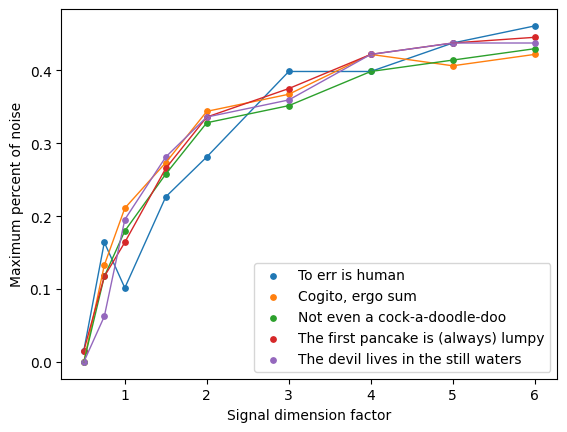

signal_dims=[0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 6]
noise_percents={'To err is human': [0.015625, 0.1640625, 0.1015625, 0.2265625, 0.28125, 0.3984375, 0.3984375, 0.4375, 0.4609375], 'Cogito, ergo sum': [0.0, 0.1328125, 0.2109375, 0.2734375, 0.34375, 0.3671875, 0.421875, 0.40625, 0.421875], 'Not even a cock-a-doodle-doo': [0.0, 0.1171875, 0.1796875, 0.2578125, 0.328125, 0.3515625, 0.3984375, 0.4140625, 0.4296875], 'The first pancake is (always) lumpy': [0.015625, 0.1171875, 0.1640625, 0.265625, 0.3359375, 0.375, 0.421875, 0.4375, 0.4453125], 'The devil lives in the still waters': [0.0, 0.0625, 0.1953125, 0.28125, 0.3359375, 0.359375, 0.421875, 0.4375, 0.4375]}


In [18]:
custom_messages = [
    "To err is human",
    "Cogito, ergo sum",
    "Not even a cock-a-doodle-doo",
    "The first pancake is (always) lumpy",
    "The devil lives in the still waters",
]

signal_dims = [0.5, 0.75, 1, 1.5, *range(2, 7)]
noise_percents = plot_signal_dim_factors(custom_messages, signal_dims, seed=420)
print(f"{signal_dims=}")
print(f"{noise_percents=}")

## Question 6


_Q6: Now implement the Dikin’s method presented at the end of the first part of the course to
solve problem (1). Compare the results obtained between Dikin’s method and the linear
solvers provided by SciPy_


To start the Dikin's method, we first need to get a point from the feasible set of our problem.

Since the dimension of our problem is quite large, we decided to use the "dirty" method of getting the starting point. To do this, we had to solve the following problem in a standard form (from slides):


$$
\begin{aligned}
& \min\limits_{\tilde{x} \in \mathbb{R}^{2p+3m}} 0 \\
\textbf{s.t. } &A' \tilde{x} = b \\
&\tilde{x} \geq \epsilon,
\end{aligned}
$$

where

$c \in \mathbb{R}^{2p+3m} = 0 $,

$\epsilon > 0$ - small constant,

and other notations are the same to the one in definition of linear problem in standard form from Question 3.


In [19]:
def get_dikin_initial_point(
    encoding_matrix: np.ndarray,
    noisy_signal: np.ndarray,
    epsilon: float,
    seed: Optional[int] = None,
) -> np.ndarray:
    """Extracts dirty initial point for Dikin's method using standard form of
    linear optimization problem

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal

    Returns:
         np.ndarray: solution to the problem
    """
    if seed is not None:
        np.random.seed(seed)

    # Size of A
    (m, p) = encoding_matrix.shape

    c = np.zeros(2 * p + 3 * m)

    b = np.concat([-np.ones(p), -noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat(
                [
                    np.concat([-np.identity(p), np.zeros((p, m))], axis=1),
                    np.concat(
                        [-encoding_matrix, np.identity(m)],
                        axis=1,
                    ),
                    np.concat(
                        [
                            encoding_matrix,
                            np.identity(m),
                        ],
                        axis=1,
                    ),
                ]
            ),
            -np.identity(p + 2 * m),
        ],
        axis=1,
    )

    res = scipy.optimize.linprog(
        c,
        A_eq=A,
        b_eq=b,
        bounds=[(epsilon, None) for _ in range(2 * p + 3 * m)],
        method="highs",
    )

    return res.x

In [ ]:
def extract_message_dikin(
    encoding_matrix: np.ndarray,
    x0: np.ndarray,
    iterations: int = 10,
    alpha: float = 1.0,
    log_on_change: bool = False,
    verbose: bool = True,
    seed: Optional[int] = None,
    true_message: Optional[str] = None,
) -> tuple[np.ndarray, np.ndarray, list[float], float]:
    """Extracts message using Dikin's method

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        x0 (np.ndarray): initial point
        iterations (int): maximum iterations of algorithm
        alpha (float): delta scale factor
        log_on_change (bool): whether to log only id message changes
        verbose (bool): enable logging
        seed (Optional[int]): Sid from Ice Age cartoon
        true_message (Optional[str]): target message

    Returns:
        tuple[np.ndarray, np.ndarray, list[float], float]: (solution to the problem,
        extracted message, objective function values logs, total running time)
    """
    if seed is not None:
        np.random.seed(seed)

    # Setup
    (m, p) = encoding_matrix.shape

    c = np.zeros(2 * p + 3 * m)
    c[p : p + m] = np.ones(m)

    A = np.concat(
        [
            np.concat(
                [
                    np.concat([-np.identity(p), np.zeros((p, m))], axis=1),
                    np.concat(
                        [-encoding_matrix, np.identity(m)],
                        axis=1,
                    ),
                    np.concat(
                        [
                            encoding_matrix,
                            np.identity(m),
                        ],
                        axis=1,
                    ),
                ]
            ),
            -np.identity(p + 2 * m),
        ],
        axis=1,
    )

    x = x0.copy()

    # Dikin's method
    message_prev, _binary_matrix = decoding_bin(x[:p], dimension)
    objective = c.dot(x)

    if verbose:
        print(f"init| msg: {message_prev} | objective: {objective :<8.3f}")

    objective_values = [float(objective)]

    start_time = time.time()

    for k in range(iterations):
        H = np.diag(1 / (x**2 + 1e-7))
        H_inv = np.linalg.inv(H)
        A_H_inv = A @ H_inv
        nu = -1 * np.linalg.inv(A_H_inv @ A.T) @ A_H_inv @ c

        s = -1 * H_inv @ (c + A.T @ nu)
        mu = 1 / np.sqrt(s.T @ H @ s)

        delta_x = mu * s

        x = x + alpha * delta_x

        message_decoded, _binary_matrix = decoding_bin(x[:p], dimension)

        objective = c.dot(x)
        objective_values.append(float(objective))

        if verbose and (not log_on_change or message_prev != message_decoded):
            message_prev = message_decoded
            print(
                f"{k :<4}| msg: {message_decoded} | objective: {objective :<8.3f} | time: {(time.time()-start_time) :.3f}s"
            )

        if true_message and (true_message == message_decoded):
            break

    total_time = time.time() - start_time

    if verbose:
        print(
            f"fin | msg: {message_decoded} | objective: {objective :<8.3f} | time: {(time.time()-start_time) :.3f}s"
        )

    return x, x[:p], objective_values, total_time

In [ ]:
def extract_decoded_dikin(
    message: str,
    signal_dim_factor: int,
    noise_percent: float,
    iterations: int,
    initial_eps: float = 1e-5,
    verbose: bool = True,
    plot_graph: bool = True,
    seed: Optional[int] = None,
) -> tuple[np.ndarray, str, list[float], float]:
    """Encodes given message with provided noise level and extracts it using Dikin's method
    (logging number of iterations and objective function values for analysis)

    Args:
        message (str): input message
        signal_dim_factor (int): factor of signal dimention
        noise_percent (float): percent of noise in signal
        iterations (int): maximum number of iterations of algorithm
        initial_eps (float): epsilon value for 'dirty' way of finding initial point
        verbose (bool): enable logging
        plot_graph (bool): enable graph plotting
        seed (Optional[int]): Sid from Ice Age cartoon

    Returns:
        tuple[np.ndarray, str, list[float], float]: (solution to the problem, decoded message,
        objective function values logs, total running time)
    """
    if verbose:
        print(f"{message=}")
    x_bin_dik, y_dik, encoding_matrix_dik, dim_dik = crypt_message(
        message, signal_dim_factor, seed=seed
    )
    noise_dik = noisy_channel(y_dik, percent_error=noise_percent, seed=seed)

    # Dikin
    x_dirty = get_dikin_initial_point(encoding_matrix_dik, noise_dik, initial_eps, seed=seed)

    solution, encoded_message, objective_values, total_time = extract_message_dikin(
        encoding_matrix_dik,
        x_dirty,
        iterations=iterations,
        log_on_change=True,
        seed=seed,
        verbose=verbose,
        true_message=message,
    )
    message_decoded, _binary_matrix = decoding_bin(encoded_message, dim_dik)

    if verbose:
        print(f"{message_decoded=}")

    # Plot
    if verbose and plot_graph:
        iteration_values = list(range(len(objective_values)))
        plt.plot(iteration_values, objective_values, label=message, linewidth=1)

        plt.legend()
        plt.xlabel("Iteration")
        plt.ylabel("Objective function value")
        plt.title(f"Initial: {message}\nFound: {message_decoded}")
        plt.show()

    return solution, message_decoded, objective_values, total_time

Since Dikin's algorithm struggles with long messages, we decided to test it on shorter one.

message='hey!'
init| msg:  ee% | objective: 100.278 
19  | msg:  eu% | objective: 92.391   | time: 0.201s
20  | msg: (eu% | objective: 91.239   | time: 0.208s
29  | msg: (eq% | objective: 85.755   | time: 0.308s
70  | msg: (eq! | objective: 79.193   | time: 0.592s
111 | msg: (ey! | objective: 70.349   | time: 0.867s
141 | msg: hey! | objective: 66.146   | time: 1.031s
fin | msg: hey! | objective: 66.146   | time: 1.031s
message_decoded='hey!'


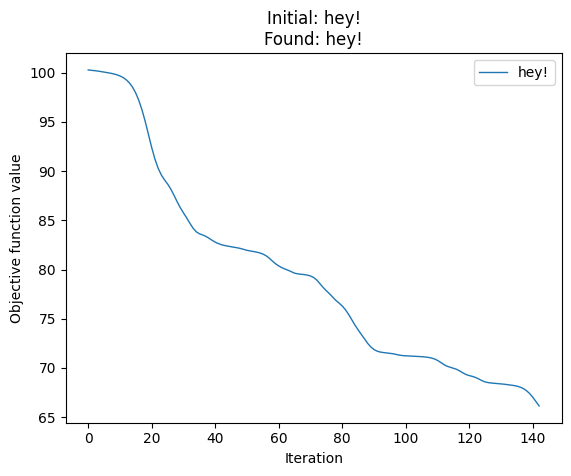

elapsed_time=1.031395673751831


In [22]:
_, __, objective_values, elapsed_time = extract_decoded_dikin(
    "hey!",
    signal_dim_factor=2,
    noise_percent=0.2,
    iterations=500,
    seed=420,
)
print(f"{elapsed_time=}")

message='I like Jubilee cookies!'
init| msg: À Yyia NuÂ-,d%2cMkkH%s# | objective: 1032.458
0   | msg: À Yyia NuÂm,d%2cMkkH%s# | objective: 1032.085 | time: 0.179s
11  | msg: À Yyia NuÂm,d%2cMkkh%s# | objective: 1027.631 | time: 2.466s
21  | msg: À Yyia Nuâm,d%2cMkkh%s# | objective: 1017.850 | time: 3.651s
26  | msg: È Yyia Nuâm,d%2cMkkh%s# | objective: 1012.730 | time: 4.506s
47  | msg: È Yyia Nuâmle%2cMkkh%s# | objective: 983.496  | time: 8.924s
74  | msg: È ]yia Nuâmle%2cMkkh%s# | objective: 918.332  | time: 16.538s
78  | msg: È ]yia Nuâmle%0cMkkh%s# | objective: 910.953  | time: 18.327s
79  | msg: É ]yia Nuâmle%0cMkkh%s# | objective: 908.923  | time: 18.637s
87  | msg: Ë ]yia Nuâmle%0cMkkh%s# | objective: 892.448  | time: 23.032s
88  | msg: Ë ]yia Nuâmle%0cMokh%s# | objective: 890.355  | time: 23.360s
90  | msg: Ë ]yia Juâmle%0cMokh%s# | objective: 886.750  | time: 23.860s
98  | msg: Ë ]yia Jubmle%0cMokh%s# | objective: 876.504  | time: 26.719s
106 | msg: É ]yia Jubmle%0cMokh%s# | o

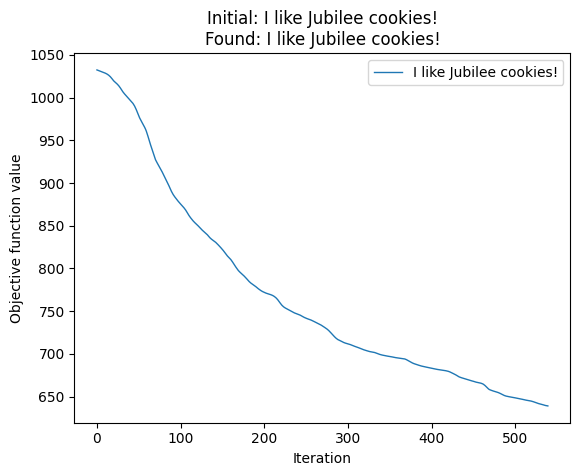

elapsed_time=92.62298393249512


In [ ]:
message_dik = "I like Jubilee cookies!"
_, __, objective_values, elapsed_time = extract_decoded_dikin(
    message_dik,
    signal_dim_factor=2,
    noise_percent=0.2,
    iterations=600,
    seed=420,
)
print(f"{elapsed_time=}")
pd.DataFrame(objective_values, columns=["objective"]).to_csv("./data/dikin_single.csv")

In [24]:
def find_noise_level_binary_dik(
    message: str,
    max_alg_iterations: int,
    signal_dim_factor: float = 4,
    initial_eps: float = 1e-5,
    eps: float = 0.01,
    max_iter: int = 10,
    verbose: bool = True,
    seed: Optional[int] = None,
):
    float_custom, y_custom, encoding_matrix_custom, dimensions_custom = crypt_message(
        message, signal_dim_factor, seed=seed
    )

    low_bound = 0.0
    up_bound = 1.0

    if verbose:
        print(f"Message: {message}")

    noise_logs = []
    objective_logs = []

    with tqdm(range(max_iter), disable=not verbose) as loop:
        for _ in loop:
            if up_bound - low_bound < eps:
                break
            current = (low_bound + up_bound) / 2

            noise_custom = noisy_channel(y_custom, percent_error=current, seed=seed)

            # Dikin
            x_dirty = get_dikin_initial_point(
                encoding_matrix_custom, noise_custom, initial_eps, seed=seed
            )

            solution, encoded_message, objective_values, total_time = extract_message_dikin(
                encoding_matrix_custom,
                x_dirty,
                iterations=max_alg_iterations,
                seed=seed,
                verbose=False,
                true_message=message,
            )
            message_decoded, _binary_matrix = decoding_bin(encoded_message, dimensions_custom)

            # Search
            comp_res = False
            if message_decoded == message:
                comp_res = True
                low_bound = current
            else:
                up_bound = current

            # Log
            noise_logs.append(current)
            objective_logs.append(objective_values)

            loop.set_postfix(
                {
                    "norm_error": np.linalg.norm(float_custom - encoded_message),
                    "max_noise_percent": low_bound,
                    "current_noise_percent": current,
                    "comp_result": bool(comp_res),
                },
            )

        if verbose:
            for noise_level, objective_vals in zip(noise_logs, objective_logs):
                iteration_values = list(range(len(objective_vals)))
                plt.plot(
                    iteration_values,
                    objective_vals,
                    label=f"{noise_level*100:.1f}% of noise",
                    linewidth=1,
                )
                plt.scatter(iteration_values[-1], objective_vals[-1], s=15)

            plt.legend()
            plt.xlabel("Iteration")
            plt.ylabel("Objective function value")
            plt.title(message)
            plt.show()

    return low_bound, noise_logs, objective_logs

Message: hey!


 70%|███████   | 7/10 [00:14<00:06,  2.01s/it, norm_error=1.11, max_noise_percent=0.242, current_noise_percent=0.242, comp_result=1]    


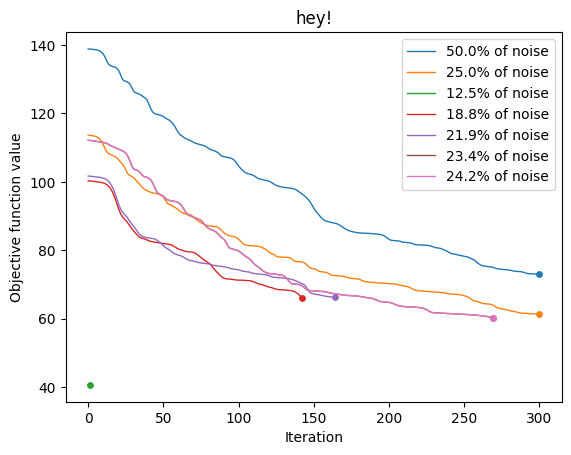

In [25]:
low_bound_dik, noise_logs_dik, objective_logs_dik = find_noise_level_binary_dik(
    "hey!", signal_dim_factor=2, max_alg_iterations=300, seed=420
)

Message: I like Jubilee cookies!


 70%|███████   | 7/10 [48:12<20:39, 413.18s/it, norm_error=2.19, max_noise_percent=0.273, current_noise_percent=0.273, comp_result=1]


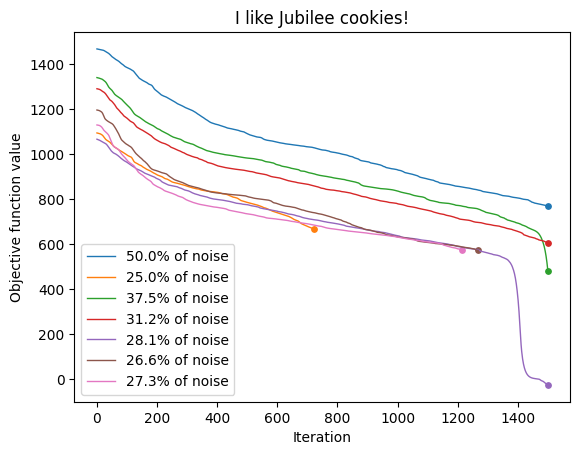

In [26]:
low_bound_dik, noise_logs_dik, objective_logs_dik = find_noise_level_binary_dik(
    message_dik, signal_dim_factor=2, max_alg_iterations=600, seed=420
)
pd.DataFrame(data=list(zip_longest(*objective_logs_dik)), columns=noise_logs_dik).to_csv(
    "./data/dikin_multiple.csv"
)

In [30]:
noise_percents = plot_signal_dim_factors([message_dik], [2], plot_graph=False, seed=420)
print(f"{noise_percents=}")

noise_percents={'I like Jubilee cookies!': [0.359375]}


As you can see, the Dikin's algorithm is applicable for message decoding.

However, this method is very sensitive to initial point. In order to find it, we have to solve sub-problem. In comparison to other methods, Dikin's requires more computation time and resources.

Moreover, SciPy solvers do not require initial point in feasible set to start.

Furthermore, SciPy methods are more robust, since they support 36% noise level, when Dikin's method can handle only 27%.

It also seems to be, that Dikin's method does not work with degenerate vertices ("from professor Leplat")

In conclusion, SciPy approaches look more preferable (at least for the given problem)

## Question 7


_Q6: Use SciPy’s linear solver by imposing binary variables: can you decipher your message
with a higher noise level?_


In [27]:
def extract_message_integer(
    encoding_matrix: np.ndarray, noisy_signal: np.ndarray, time_limit_s: float = 120
) -> tuple[np.ndarray, np.ndarray]:
    """Extracts message using (almost) geometric form of linear optimization problem
    with integer integrality

    Args:
        encoding_matrix (np.ndarray): encoding matrix
        noisy_signal (np.ndarray): received signal
        time_limit_s (float): computation time limit in seconds

    Returns:
        tuple[np.ndarray, np.ndarray]: solution to the problem, extracted message
    """

    # Size of A
    (m, p) = encoding_matrix.shape

    c = np.zeros(p + m)
    c[p : p + m] = np.ones(m)

    integrality = np.ones(p + m) - c
    bounds = [*[(0, 1) for _ in range(p)], *[(0, None) for _ in range(m)]]

    b = np.concat([-noisy_signal, noisy_signal])

    A = np.concat(
        [
            np.concat(
                [-encoding_matrix, np.identity(m)],
                axis=1,
            ),
            np.concat(
                [
                    encoding_matrix,
                    np.identity(m),
                ],
                axis=1,
            ),
        ]
    )

    # We add minuses, because from scipy documentation
    # A_ub x <= b_ub
    # But in geometric from we have constraints
    # A_ub x >= b_ub
    res = scipy.optimize.linprog(
        c,
        A_ub=-A,
        b_ub=-b,
        options={"maxiter": 20, "time_limit": time_limit_s},
        integrality=integrality,
        bounds=bounds,
    )
    return res.x, res.x[:p]

In [28]:
noise_percents_int = plot_signal_dim_factors(
    custom_messages,
    [2],
    extract_fn=extract_message_integer,
    verbose=True,
    seed=420,
    plot_graph=False,
)
print(f"{noise_percents_int=}")

Message: To err is human


 70%|███████   | 7/10 [09:54<04:14, 84.98s/it, norm_error=1.88e-11, max_noise_percent=0.398, current_noise_percent=0.398, comp_result=1]


Message: Cogito, ergo sum


 70%|███████   | 7/10 [10:33<04:31, 90.46s/it, norm_error=1.95e-11, max_noise_percent=0.383, current_noise_percent=0.383, comp_result=1] 


Message: Not even a cock-a-doodle-doo


 70%|███████   | 7/10 [11:19<04:51, 97.10s/it, norm_error=3.59e-10, max_noise_percent=0.398, current_noise_percent=0.398, comp_result=1] 


Message: The first pancake is (always) lumpy


 70%|███████   | 7/10 [12:02<05:09, 103.23s/it, norm_error=1, max_noise_percent=0.375, current_noise_percent=0.383, comp_result=0]     


Message: The devil lives in the still waters


 70%|███████   | 7/10 [12:01<05:09, 103.14s/it, norm_error=1, max_noise_percent=0.391, current_noise_percent=0.398, comp_result=0]       

noise_percents_int={'To err is human': [0.3984375], 'Cogito, ergo sum': [0.3828125], 'Not even a cock-a-doodle-doo': [0.3984375], 'The first pancake is (always) lumpy': [0.375], 'The devil lives in the still waters': [0.390625]}
